---
# **Small Traffic Dataset Modeling**
##**CS 4824 Final Report**
---

## **Introduction**

This is part of my CS 4824 final project at Virginia Tech in Spring '24. I am researching the effectiveness of different types of machine learning models on traffic data prediction. Due to relatively limited time and resources, I am look at a small dataset and three different models:

1. LSTM RNN from [this paper](https://ieeexplore.ieee.org/document/7463717)
2. KNN from [this paper](https://iopscience.iop.org/article/10.1088/1742-6596/1213/5/052070/pdf)
3. A "homebrew" solution

### Dataset

This dataset is retrieved from [FEDESORIANO on Kaggle](https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset/code). This dataset is used for academic purposes in line with the dataset description on Kaggle. A similiar process was carried out by HEMARAU VARADI [here](https://www.kaggle.com/code/hemarajuvaradi/traffic-prediction-using-rnn-and-lstm), which was a great inspiration.

The dataset has 48,120 entries representing hourly traffic data at 4 different traffic junctions. There are three features: DateTime, Junction, and Vehicles. The Junction feature is a number 1-4 indicating the traffic junction. The Vehicles feature indicates the number of vehicles flowing through that junction. There is also an ID field provided in the dataset which will be disregarded here. The dataset spans from November 1st, 2015 to July 1st, 2017.

In [ ]:
# Bulk import
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Keras imports
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout, InputLayer

## **Importing and Format Data**
Data is imported using a standard Google Colab import. Please note to change this based on your Colab layout or if you are running this as a local Jupyter Notebook.


In [ ]:
# NOTE: MODIFY THIS SECTION TO REFLECT FILE PATHS OR IF USING IT OUTSIDE OF COLAB

prefix = '/content/drive/My Drive/'
path_to_data_folder = 'Colab Notebooks/ML-Project'
sys_path = prefix + path_to_data_folder
sys.path.append(sys_path)

small_traffic_path = os.path.join(sys_path, 'small-traffic.csv')
print('Path to data file: {}'.format(small_traffic_path))
drive.mount('/content/drive')

Path to data file: /content/drive/My Drive/Colab Notebooks/ML-Project/small-traffic.csv
Mounted at /content/drive


In [ ]:
# Import the data and see a preview
data = pd.read_csv(small_traffic_path)
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


We will also look at the shape and types of the data to ensure that we know what we are working with. We will also validate that there are no unexpected values. More thorough preprocessing will be done later.

In [ ]:
print("Full data shape:", data.shape)
print()
print("Data type breakdown:")
print(data.dtypes)
print()

# Reassign data to just the junction
data = data[data['Junction']==1]
print("Single junction data shape:", data.shape)
print()
print("Validate no nulls:")
print(data.isnull().sum()/data.count()*100)

Full data shape: (48120, 4)

Data type breakdown:
DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

Single junction data shape: (14592, 4)

Validate no nulls:
DateTime    0.0
Junction    0.0
Vehicles    0.0
ID          0.0
dtype: float64


# **Model 1: LSTM Model**
Here the model contains an LSTM layer followed by a dense layer. The LSTM layer has 70 cell units. This time the number of epochs was set to 3000 and the result is shown below.

In [ ]:
def train_test_val_split(df, val_split, test_split, window_size=12):
    """
    Splits a pandas dataframe into training, validation, and testing data

    arguments:
    ----------
    df (dataframe): dataframe with the list of data
    val_split (float): proportion of validation data (0 to 1)
    test_split (float): proportion of test data (0 to 1)
    window_size (int): dictates input size into RNN

    returns:
    --------
    tuple: train_X, train_Y, val_X, val_Y, test_X, test_Y

    """

    df_as_np = df.to_numpy()
    X, Y = [], []
    for i in range(len(df_as_np)-window_size):
        row = [[j] for j in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        Y.append(label)
    np_X = np.array(X)
    np_Y = np.array(Y)

    # Perform the split
    val_count = int( len(df_as_np) * val_split)
    test_count = int( len(df_as_np) * test_split)
    train_count = len(df_as_np) - val_count - test_count

    train_X, train_Y = np_X[:train_count], np_Y[:train_count]
    val_X, val_Y = np_X[train_count:train_count+val_count], np_Y[train_count:train_count+val_count]
    test_X, test_Y = np_X[train_count+val_count:], np_Y[train_count+val_count:]

    return train_X, train_Y, val_X, val_Y, test_X, test_Y



train_X, train_Y, val_X, val_Y, test_X, test_Y = train_test_val_split(data['Vehicles'], 0.1, 0.1)
print(train_X.shape, train_Y.shape, val_X.shape, val_Y.shape, test_X.shape, test_Y.shape)

(11674, 12, 1) (11674,) (1459, 12, 1) (1459,) (1447, 12, 1) (1447,)


In [ ]:
model1 = Sequential()
model1.add(InputLayer((12, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training the model varies pretty significantly based on the pseduo-random starting conditions. An expected validation RMSE should be less than 100 to start. If it starts higher, restart the training process immediatly.

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.fit(train_X, train_Y, validation_data=(val_X, val_Y), batch_size=64, epochs=100, callbacks=[cp1], verbose=1)

Epoch 1/100
183/183 [==============================] - 11s 42ms/step - loss: 1910.0811 - root_mean_squared_error: 43.7045 - val_loss: 4244.2720 - val_root_mean_squared_error: 65.1481
Epoch 2/100
183/183 [==============================] - 8s 45ms/step - loss: 1766.2148 - root_mean_squared_error: 42.0264 - val_loss: 3932.8040 - val_root_mean_squared_error: 62.7121
Epoch 3/100
183/183 [==============================] - 6s 35ms/step - loss: 1476.8356 - root_mean_squared_error: 38.4296 - val_loss: 3395.6921 - val_root_mean_squared_error: 58.2726
Epoch 4/100
183/183 [==============================] - 7s 41ms/step - loss: 1248.7916 - root_mean_squared_error: 35.3382 - val_loss: 3026.1602 - val_root_mean_squared_error: 55.0105
Epoch 5/100
183/183 [==============================] - 7s 41ms/step - loss: 1079.0621 - root_mean_squared_error: 32.8491 - val_loss: 2758.4312 - val_root_mean_squared_error: 52.5208
Epoch 6/100
183/183 [==============================] - 7s 41ms/step - loss: 957.0427 - ro

365/365 [==============================] - 1s 2ms/step


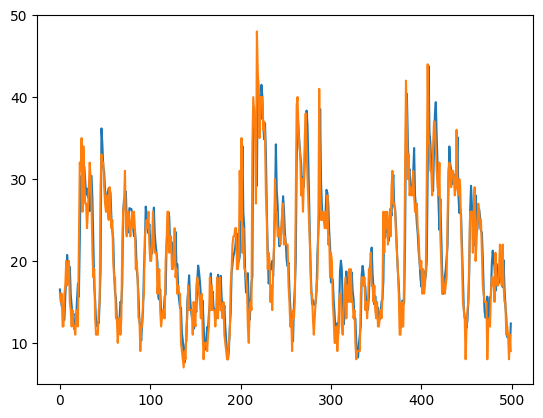

In [ ]:
model1 = keras.saving.load_model('lstm-rnn.keras')
train_predictions = model1.predict(train_X).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':train_Y})

plt.plot(train_results['Train Predictions'][:500])
plt.plot(train_results['Actuals'][:500])

46/46 [==============================] - 0s 2ms/step


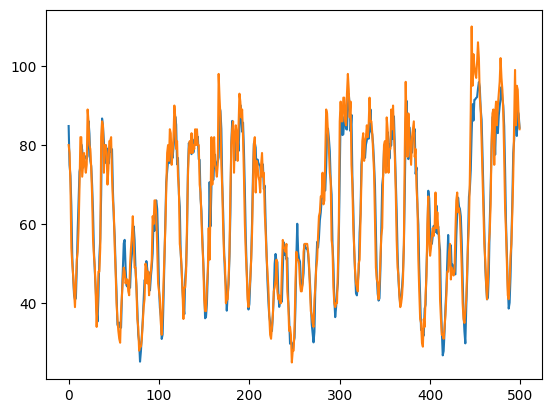

In [ ]:
val_predictions = model1.predict(val_X).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':val_Y})
plt.plot(val_results['Val Predictions'][:500])
plt.plot(val_results['Actuals'][:500])

46/46 [==============================] - 0s 3ms/step


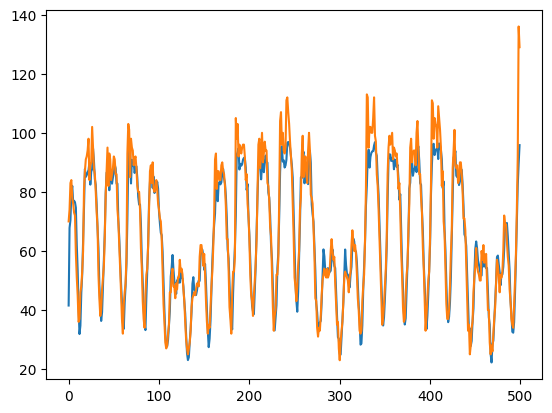

In [ ]:
test_predictions = model1.predict(test_X).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':test_Y})
plt.plot(test_results['Test Predictions'][:500])
plt.plot(test_results['Actuals'][:500])

## **Model Evaluation**



In [ ]:
from math import sqrt
# Compute MAPE and RMSE
train_MAPE = mean_absolute_percentage_error(train_Y, train_predictions)
train_RMSE = sqrt(mean_squared_error(train_Y, train_predictions))
val_MAPE = mean_absolute_percentage_error(val_Y, val_predictions)
val_RMSE = sqrt(mean_squared_error(val_Y, val_predictions))
test_MAPE = mean_absolute_percentage_error(test_Y, test_predictions)
test_RMSE = sqrt(mean_squared_error(test_Y, test_predictions))

accuracy_data = {
    'DataType': ['Train', 'Validation', 'Test'],
    'MAPE': [train_MAPE, val_MAPE, test_MAPE],
    'RMSE': [train_RMSE, val_RMSE, test_RMSE]
}

lstm_rnn_results = pd.DataFrame(accuracy_data)
print(lstm_rnn_results)

     DataType      MAPE      RMSE
0       Train  0.089917  4.415014
1  Validation  0.068821  5.450624
2        Test  0.086324  8.734023


In [ ]:
model1.save('lstm-rnn.keras')

# **Model 2: KNN**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

model2 = KNeighborsRegressor(20)

# Change training data to remove singleton
train_X = np.squeeze(train_X)
val_X = np.squeeze(val_X)
test_X = np.squeeze(test_X)

model2.fit(train_X, train_Y)

KNeighborsRegressor(n_neighbors=20)

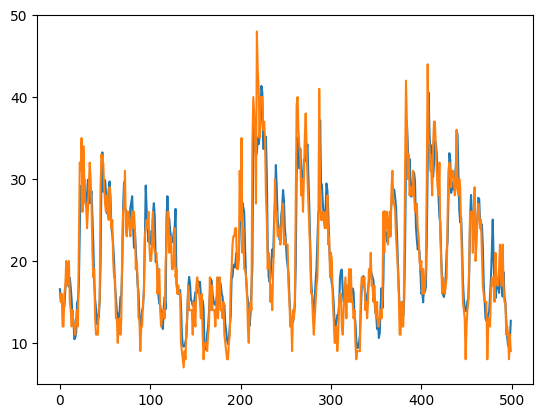

In [ ]:
train_predictions = model2.predict(train_X).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':train_Y})

plt.plot(train_results['Train Predictions'][:500])
plt.plot(train_results['Actuals'][:500])

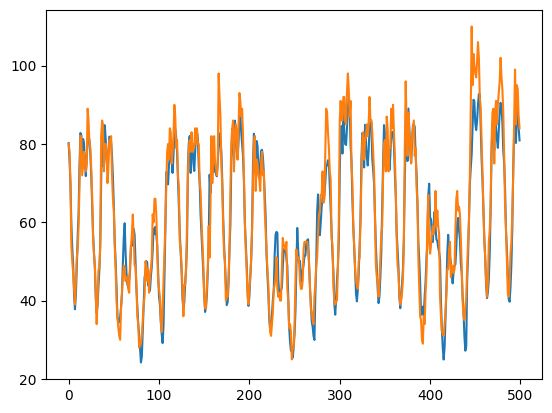

In [ ]:
val_predictions = model2.predict(val_X).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':val_Y})
plt.plot(val_results['Val Predictions'][:500])
plt.plot(val_results['Actuals'][:500])

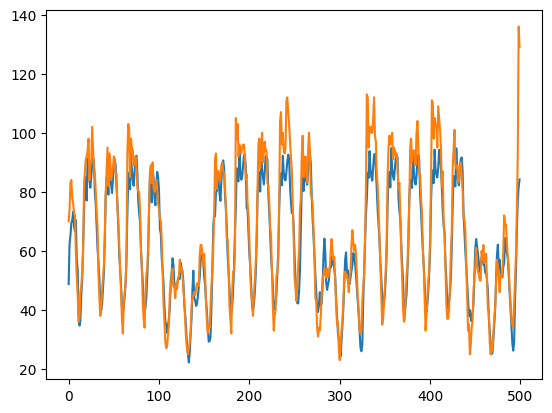

In [ ]:
test_predictions = model2.predict(test_X).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':test_Y})
plt.plot(test_results['Test Predictions'][:500])
plt.plot(test_results['Actuals'][:500])

## **Model Evaluation**

In [ ]:
from math import sqrt

# Compute MAPE and RMSE
train_MAPE = mean_absolute_percentage_error(train_Y, train_predictions)
train_RMSE = sqrt(mean_squared_error(train_Y, train_predictions))
val_MAPE = mean_absolute_percentage_error(val_Y, val_predictions)
val_RMSE = sqrt(mean_squared_error(val_Y, val_predictions))
test_MAPE = mean_absolute_percentage_error(test_Y, test_predictions)
test_RMSE = sqrt(mean_squared_error(test_Y, test_predictions))

accuracy_data = {
    'DataType': ['Train', 'Validation', 'Test'],
    'MAPE': [train_MAPE, val_MAPE, test_MAPE],
    'RMSE': [train_RMSE, val_RMSE, test_RMSE]
}

knn_results = pd.DataFrame(accuracy_data)
print(knn_results)

     DataType      MAPE       RMSE
0       Train  0.083717   4.126534
1  Validation  0.069981   5.796346
2        Test  0.114887  11.550950


# **Homebrew Model(s)**

These models will all be simple models that operate on basic arithmetic. They will be quick to compute

In [ ]:
def model3_avg(x):
    """
    Simply takes the average over the last 12 datapoint
    """

    return np.average(x)

def model3_repeat(x):
    """
    Returns the latest element
    """

    return x[-1]

def model3_diff_avg(x):
    """
    Takes a weighted average of the differences in the last 12 data points
    """

    x_diff = []
    x_weight = []
    cur_weight = 0.1
    for i in range(len(x)-1, -1, -1):
        x_diff.append(x[i] - x[i-1])
        x_weight.append(cur_weight)
        cur_weight = 0.8 * cur_weight

    return x[-1] + np.dot(x_diff, x_weight)

In [ ]:
# Test custom models
bulk_X = np.concatenate((train_X, val_X, test_X))
bulk_Y = np.concatenate((train_Y, val_Y, test_Y))
avg_predict = []
diff_predict = []
repeat_predict = []
for x in bulk_X:
    avg_predict.append(model3_avg(x))
    diff_predict.append(model3_diff_avg(x))
    repeat_predict.append(model3_repeat(x))

avg_MAPE = mean_absolute_percentage_error(bulk_Y, avg_predict)
avg_RMSE = sqrt(mean_squared_error(bulk_Y, avg_predict))
diff_MAPE = mean_absolute_percentage_error(bulk_Y, diff_predict)
diff_RMSE = sqrt(mean_squared_error(bulk_Y, diff_predict))
rep_MAPE = mean_absolute_percentage_error(bulk_Y, repeat_predict)
rep_RMSE = sqrt(mean_squared_error(bulk_Y, repeat_predict))

accuracy_data = {
    'DataType': ['Avg', 'Diff', 'Rep'],
    'MAPE': [avg_MAPE, diff_MAPE, rep_MAPE],
    'RMSE': [avg_RMSE, diff_RMSE, rep_RMSE]
}

custom_results = pd.DataFrame(accuracy_data)
print(custom_results)

  DataType      MAPE       RMSE
0      Avg  0.335153  16.544185
1     Diff  0.112862   6.171430
2      Rep  0.114318   6.260141


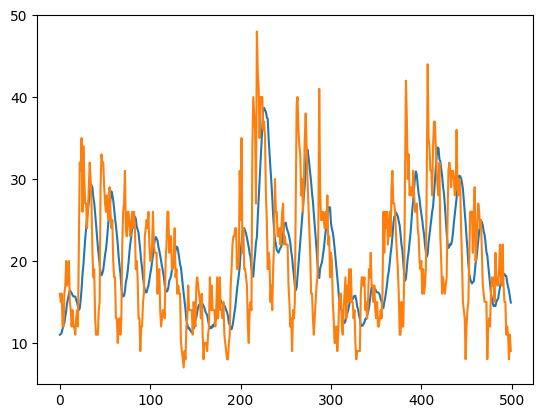

In [ ]:
avg_results = pd.DataFrame(data={'Test Predictions':avg_predict, 'Actuals':bulk_Y})
plt.plot(avg_results['Test Predictions'][:500])
plt.plot(avg_results['Actuals'][:500])

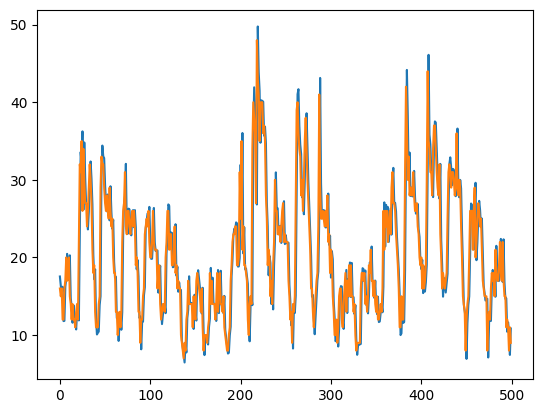

In [ ]:
diff_results = pd.DataFrame(data={'Test Predictions':diff_predict, 'Actuals':bulk_Y})
plt.plot(diff_results['Test Predictions'][:500])
plt.plot(diff_results['Actuals'][:500])

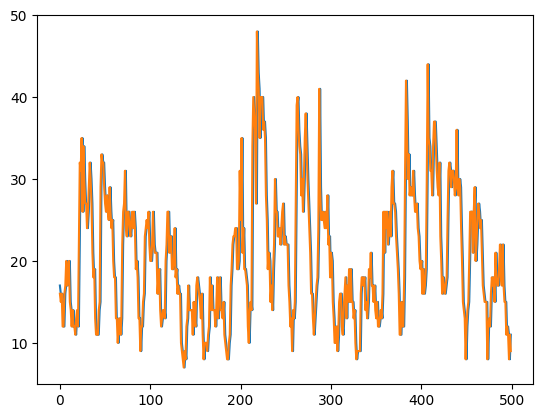

In [ ]:
rep_results = pd.DataFrame(data={'Test Predictions':repeat_predict, 'Actuals':bulk_Y})
plt.plot(rep_results['Test Predictions'][:500])
plt.plot(rep_results['Actuals'][:500])